In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import scipy.stats as si
from mpl_toolkits.mplot3d import Axes3D

In [2]:
initial_data = yf.download("SOL-USD", start="2021-04-01", end="2022-04-01")
initial_data.tail()


[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-03-27,101.773697,107.298714,99.269096,107.084221,107.084221,1572329892
2022-03-28,107.077965,113.175949,105.477875,106.465256,106.465256,2877146388
2022-03-29,106.327988,115.275719,105.999191,111.710312,111.710312,3052274877
2022-03-30,111.690254,124.605003,107.767258,120.699486,120.699486,3908170428
2022-03-31,120.681557,128.930115,120.197830,122.661461,122.661461,4115229587


In [3]:
initial_data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-03-31,19.101685,19.795801,18.156256,19.465229,19.465229,206011018
2021-04-01,19.415682,20.361540,18.844246,19.084902,19.084902,173731886
2021-04-02,19.084631,19.824574,18.568419,19.810223,19.810223,131061660
2021-04-03,19.796452,23.827188,19.789450,22.552277,22.552277,483057740
2021-04-04,22.527370,25.569532,22.212969,24.061323,24.061323,426557980


In [4]:
SOL_Price_data = initial_data['Adj Close']

In [5]:
SOL_Price_data.tail()

Date
2022-03-27    107.084221
2022-03-28    106.465256
2022-03-29    111.710312
2022-03-30    120.699486
2022-03-31    122.661461
Name: Adj Close, dtype: float64

In [6]:
SOL_Spot_price = SOL_Price_data[-1]
SOL_Spot_price

122.66146087646484

Text(0.5, 1.0, 'SOLANA')

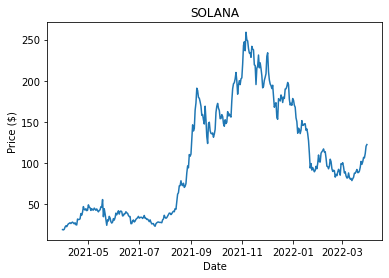

In [7]:

Fig_1 = plt.figure()
plt.plot(SOL_Price_data)
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.title('SOLANA')

In [8]:
SOL_Price_data.describe().round(2)

count    366.00
mean     104.17
std       66.76
min       19.08
25%       38.77
50%       92.92
75%      159.08
max      258.93
Name: Adj Close, dtype: float64

In [9]:
SOL_Log_Ret = np.log(SOL_Price_data / SOL_Price_data.shift(1))
SOL_Log_Ret.tail().round(4)

Date
2022-03-27    0.0510
2022-03-28   -0.0058
2022-03-29    0.0481
2022-03-30    0.0774
2022-03-31    0.0161
Name: Adj Close, dtype: float64

In [10]:
SOL_Vol = np.sqrt(365) * SOL_Log_Ret.std()
print(SOL_Vol)





1.4166160625504183


In [11]:
def SOLANA_euro_option_bs(S, K, T, r, vol, payoff):
    
    #S: spot price
    #K: strike price
    #T: time to maturity
    #r: risk free rate
    #SOL_vol: volatility of Solana
    #payoff: call or put
    
    d1 = (np.log(S / K) + (r + 0.5 * vol** 2) * T) / (vol * np.sqrt(T))
    d2 = (np.log(S / K) + (r - 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    if payoff == "call":
        SOLANA_option_value = S * si.norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0)
    elif payoff == "put":
        SOLANA_option_value = - S * si.norm.cdf(-d1, 0.0, 1.0) + K * np.exp(-r * T) * si.norm.cdf(-d2, 0.0, 1.0)
    
    return SOLANA_option_value

In [12]:
#payoff: call
#Call Option
# S = SOL_Spot_price
# K = 130
# r = 0.016
# T= 30/365

print("The SOLANA Call Option price is $", round(SOLANA_euro_option_bs(SOL_Spot_price, 130, 30/365, 0.016, SOL_Vol , 'call'),2))

The SOLANA Call Option price is $ 16.93


In [13]:
def delta(S, K, T, r, q, vol, payoff):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    if payoff == "call":
        delta = np.exp(-q * T) * si.norm.cdf(d1, 0.0, 1.0)
    elif payoff == "put":
        delta =  - np.exp(-q * T) * si.norm.cdf(-d1, 0.0, 1.0)
    
    return delta

In [14]:

delta(SOL_Spot_price, 130, 30/365, 0.016, 0, SOL_Vol, 'call')

0.5252087425488521

In [15]:
delta(SOL_Spot_price, 130, 30/365, 0.016, 0, SOL_Vol, 'put')

-0.4747912574511479

In [16]:
S = np.linspace(100,200,11)
Delta_Call = np.zeros((len(S),1))
Delta_Put = np.zeros((len(S),1))
for i in range(len(S)):
    Delta_Call [i] = delta(S[i], 130, 30/365, 0.016, 0, SOL_Vol, 'call')
    Delta_Put [i] = delta(S[i], 130, 30/365, 0.016, 0, SOL_Vol, 'put')

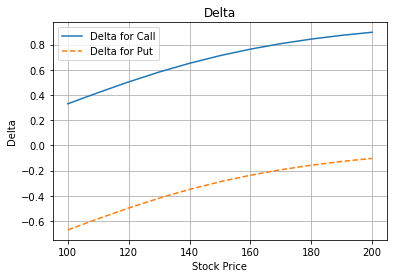

In [17]:
fig = plt.figure()
plt.plot(S, Delta_Call, '-')
plt.plot(S, Delta_Put, '--')
plt.grid()
plt.xlabel('Stock Price')
plt.ylabel('Delta')
plt.title('Delta')
plt.legend(['Delta for Call','Delta for Put'])

In [18]:
def gamma(S, K, T, r, q, vol, payoff):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    gamma = np.exp(- q * T) * si.norm.pdf(d1, 0.0, 1.0) / (vol * S * np.sqrt(T))
    
    return gamma

In [19]:
gamma(SOL_Spot_price, 130, 30/365, 0.016, 0, SOL_Vol, 'call')

0.007992219175455745

In [20]:
gamma(SOL_Spot_price, 130, 30/365, 0.016, 0, SOL_Vol, 'put')

0.007992219175455745

In [21]:
S = np.linspace(50,150,11)
Gamma = np.zeros((len(S),1))
for i in range(len(S)):
    Gamma [i] = gamma(S[i], 130, 30/365, 0.016, 0, SOL_Vol, 'call')


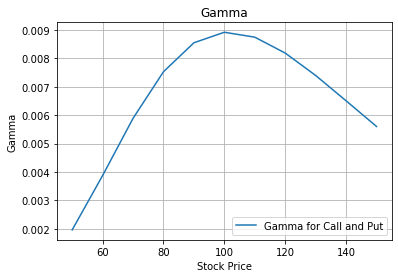

In [22]:
fig = plt.figure()
plt.plot(S, Gamma, '-')
plt.grid()
plt.xlabel('Stock Price')
plt.ylabel('Gamma')
plt.title('Gamma')
plt.legend(['Gamma for Call and Put'])

In [23]:
def speed(S, K, T, r, q, vol, payoff):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    speed = - np.exp(-q * T) * si.norm.pdf(d1, 0.0, 1.0) / ((vol **2) * (S**2) * np.sqrt(T)) * (d1 + vol * np.sqrt(T))
    
    return speed

In [24]:
speed(SOL_Spot_price, 130, 30/365, 0.016, 0, SOL_Vol, 'call')

-2.158814149621681e-05

In [25]:
speed(SOL_Spot_price, 130, 30/365, 0.016, 0, SOL_Vol, 'put')

-2.158814149621681e-05

In [26]:
S = np.linspace(50,150,11)
Speed = np.zeros((len(S),1))
for i in range(len(S)):
    Speed [i] = speed(S[i], 130, 30/365, 0.016, 0, SOL_Vol, 'call')

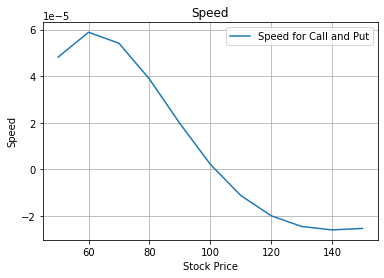

In [27]:
fig = plt.figure()
plt.plot(S, Speed, '-')
plt.grid()
plt.xlabel('Stock Price')
plt.ylabel('Speed')
plt.title('Speed')
plt.legend(['Speed for Call and Put'])

In [28]:
def theta(S, K, T, r, q, vol, payoff):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    d2 = (np.log(S / K) + (r - q - 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    if payoff == "call":
        theta = vol * S * np.exp(-q * T) * si.norm.pdf(d1, 0.0, 1.0) / (2 * np.sqrt(T)) - q * S * np.exp(-q * T) * si.norm.cdf(d1, 0.0, 1.0) + r * K * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0)
    elif payoff == "put":
        theta = vol * S * np.exp(-q * T) * si.norm.pdf(-d1, 0.0, 1.0) / (2 * np.sqrt(T)) - q * S * np.exp(-q * T) * si.norm.cdf(-d1, 0.0, 1.0) + r * K * np.exp(-r * T) * si.norm.cdf(-d2, 0.0, 1.0)
    
    return theta

In [29]:
theta(SOL_Spot_price, 130, 30/365, 0.016, 0, SOL_Vol, 'call')

121.41845627803634

In [30]:
theta(SOL_Spot_price, 130, 30/365, 0.016, 0, SOL_Vol, 'put')

121.97584174559256

In [31]:
T = np.linspace(0.01,60/365,12)
Theta_Call = np.zeros((len(T),1))
Theta_Put = np.zeros((len(T),1))
for i in range(len(T)):
    Theta_Call [i] = theta(SOL_Spot_price, 140, T[i], 0.016, 0, SOL_Vol, 'call')
    Theta_Put [i] = theta(SOL_Spot_price, 140, T[i], 0.016, 0, SOL_Vol, 'put')

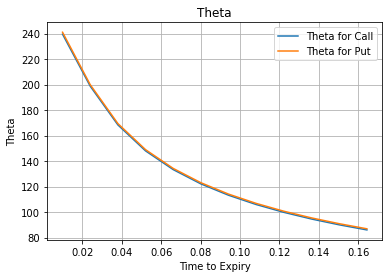

In [32]:
fig = plt.figure()
plt.plot(T, Theta_Call, '-')
plt.plot(T, Theta_Put, '-')
plt.grid()
plt.xlabel('Time to Expiry')
plt.ylabel('Theta')
plt.title('Theta')
plt.legend(['Theta for Call', 'Theta for Put'])

In [33]:
def rho(S, K, T, r, q, vol, payoff):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    d2 = (np.log(S / K) + (r - q - 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    if payoff == "call":
        rho =  K * T * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0)
    elif payoff == "put":
        rho = - K * T * np.exp(-r * T) * si.norm.cdf(-d2, 0.0, 1.0)
    
    return rho

In [34]:
rho(SOL_Spot_price, 140, 30/365, 0.016, 0, SOL_Vol, 'call')

3.4436329045795135

In [35]:
rho(SOL_Spot_price, 140, 30/365, 0.016, 0, SOL_Vol, 'put')

-8.048094061141274

In [36]:
r = np.linspace(0,0.05,11)
Rho_Call = np.zeros((len(r),1))
Rho_Put = np.zeros((len(r),1))
for i in range(len(r)):
    Rho_Call [i] = rho(SOL_Spot_price, 140, 30/365, r[i], 0, SOL_Vol, 'call')
    Rho_Put [i] = rho(SOL_Spot_price, 140, 30/365, r[i], 0, SOL_Vol, 'put')

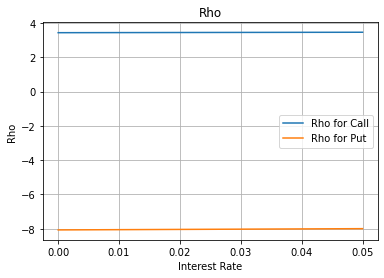

In [37]:
fig = plt.figure()
plt.plot(r, Rho_Call, '-')
plt.plot(r, Rho_Put, '-')
plt.grid()
plt.xlabel('Interest Rate')
plt.ylabel('Rho')
plt.title('Rho')
plt.legend(['Rho for Call', 'Rho for Put'])

In [38]:
def vega(S, K, T, r, q, vol, payoff):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    vega = S * np.sqrt(T) * np.exp(-q * T) * si.norm.pdf(d1, 0.0, 1.0)
    
    return vega

In [39]:
vega(SOL_Spot_price, 140, 30/365, 0.016, 0, SOL_Vol, 'call')

13.929799194215008

In [40]:
vega(SOL_Spot_price, 140, 30/365, 0.016, 0, SOL_Vol, 'put')

13.929799194215008

In [41]:
vol = np.linspace(0.1,0.4,13)
Vega = np.zeros((len(vol),1))
for i in range(len(vol)):
    Vega [i] = vega(SOL_Spot_price, 140, 30/365, 0.016, 0, vol[i] , 'call')

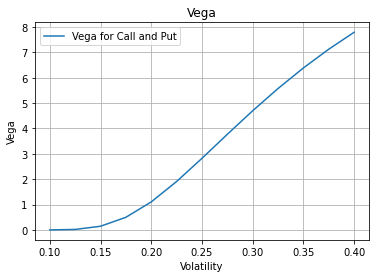

In [42]:
fig = plt.figure()
plt.plot(vol, Vega, '-')
plt.grid()
plt.xlabel('Volatility')
plt.ylabel('Vega')
plt.title('Vega')
plt.legend(['Vega for Call and Put'])

 # Monte Carlo Simulation

In [43]:
def mcs_simulation_np(p):
    M = p
    I = p
    dt = T / M 
    S = np.zeros((M + 1, I))
    S[0] = S0 
    rn = np.random.standard_normal(S.shape) 
    for t in range(1, M + 1): 
        S[t] = S[t-1] * np.exp((r - sigma ** 2 / 2) * dt + sigma * np.sqrt(dt) * rn[t]) 
    return S

In [44]:
T = 30 / 365
r = 0.016
sigma = SOL_Vol
S0 = SOL_Spot_price
K = 140


# T = time
# r = risk free rate
# sigma = volatility
# S0 = spot price
# K = Strike Price

In [52]:
S = mcs_simulation_np(20000)

# a thousand simulations 


In [53]:
S = np.transpose(S)
S

array([[122.66146088, 122.01533314, 121.92627486, ..., 103.85843684,
        103.76091226, 103.92156105],
       [122.66146088, 122.74978135, 122.74742402, ...,  48.03898294,
         47.8184487 ,  47.81340365],
       [122.66146088, 123.00398845, 122.30360785, ..., 131.35826758,
        130.9159733 , 130.53937297],
       ...,
       [122.66146088, 122.88711861, 123.89221018, ...,  96.70654669,
         96.16923604,  96.11277583],
       [122.66146088, 122.3079153 , 122.20121975, ...,  82.55033636,
         82.31601902,  82.27877759],
       [122.66146088, 122.448704  , 123.08515311, ...,  97.62894662,
         97.85079155,  97.91395233]])

Text(0.5, 1.0, 'Frequency distribution of the simulated end-of-preiod values')

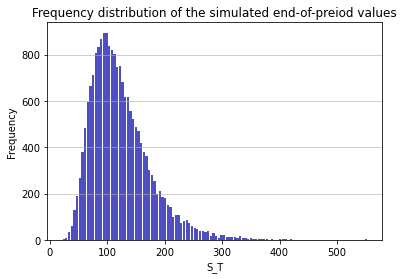

In [54]:
n, bins, patches = plt.hist(x=S[:,-1], bins='auto', color='#0504aa',alpha=0.7, rwidth=0.85)

plt.grid(axis='y', alpha=0.75)
plt.xlabel('S_T')
plt.ylabel('Frequency')
plt.title('Frequency distribution of the simulated end-of-preiod values')

In [55]:
p = np.mean(np.maximum(K - S[:,-1],0))
print('European put', str(p))

European put 30.895893816705


In [56]:
c = np.mean(np.maximum(S[:,-1] - K,0))
print('European call', str(c))

European call 13.77840236939581
